In [1]:
callin_data_path = r'D:\yyfang\201206_calls_statics\data\呼入量.xlsx'
callin_data_path = callin_data_path.strip("‪u202a")

## 导入相关库

In [2]:
import numpy as np
import pandas as pd
import time
from matplotlib import pyplot as plt
%matplotlib inline
from pylab import *
mpl.rcParams['font.sans-serif'] = ['SimHei']

In [3]:
callin_data = pd.read_excel(callin_data_path);
callin_data.head()

,呼叫时间,姓名,工号,省级分校,地市分校,座席编号,通话类型,通话ID,通话设备,主叫号码,被叫号码,响铃时长,通话状态,通话时长,满意度
0,2020-11-30 22:25:51,洪娟,55827,招生营销部,招生营销部,8011875,呼入,47191753,固定电话,13688856338,01082533610-2831,2,接通,257,非常满意
1,2020-11-30 22:23:40,郭淑琦,56390,招生营销部,招生营销部,8011881,呼入,47073334,固定电话,18995608058,01082533754-2837,4,接通,61,非常满意
2,2020-11-30 22:11:53,洪娟,55827,招生营销部,招生营销部,8011875,呼入,47172546,固定电话,15185677697,01082533471-2831,2,接通,24,NaN
3,2020-11-30 22:11:50,郭淑琦,56390,招生营销部,招生营销部,8011881,呼入,47152554,固定电话,13572540825,01082533754-2837,5,接通,131,非常满意
4,2020-11-30 21:47:42,洪娟,55827,招生营销部,招生营销部,8011875,呼入,47053257,固定电话,18846904945,01082533610-2831,6,接通,137,NaN


## 统计呼叫时间

In [4]:
def plot_frequency_data(frequency_data):
    plt.figure()
    plt.title(u'上班时间电话分布')
    plt.xlabel("时段（小时）")
    plt.ylabel("呼入量")
    plt.bar(frequency_data.index, frequency_data, width=0.3)

In [5]:
callin_data['hour'] = callin_data['呼叫时间'].apply(lambda x: time.strptime(x,'%Y-%m-%d %H:%M:%S').tm_hour*2+time.strptime(x,'%Y-%m-%d %H:%M:%S').tm_min//30)

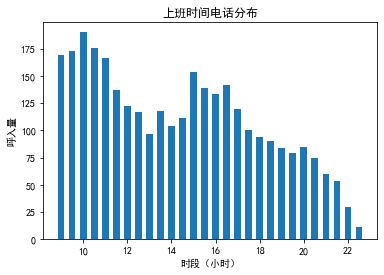

In [6]:
callin_time_frequency = callin_data['hour'].value_counts().sort_index()
callin_time_frequency = callin_time_frequency.rename('all')
callin_time_frequency.index = callin_time_frequency.index/2
plot_frequency_data(callin_time_frequency)

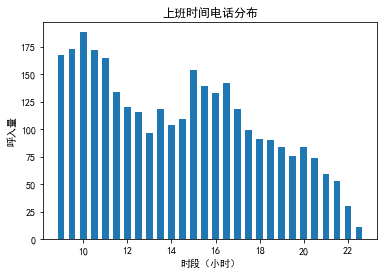

In [7]:
connection_time_frequency = callin_data.loc[callin_data['通话状态'] == '接通']['hour'].value_counts().sort_index()
connection_time_frequency = connection_time_frequency.rename('connection')
connection_time_frequency.index = connection_time_frequency.index/2
plot_frequency_data(connection_time_frequency)

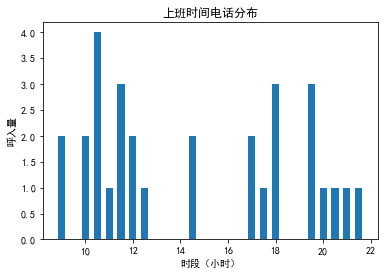

In [8]:
missing_time_frequency = callin_data.loc[callin_data['通话状态'] == '未接通']['hour'].value_counts().sort_index()
missing_time_frequency = missing_time_frequency.rename('missing')
missing_time_frequency.index = missing_time_frequency.index/2
plot_frequency_data(missing_time_frequency)

In [9]:
time_frequency = pd.concat([callin_time_frequency, connection_time_frequency, missing_time_frequency], axis =1)
time_frequency = time_frequency.fillna(0);
time_frequency['time'] = time_frequency.index
time_frequency['time'] = time_frequency['time'].apply(lambda x: '%d:%02d-%d:%02d' % (x//1, x%1*60, (x+0.5)//1, (x+0.5)%1*60))
time_frequency = time_frequency[['time', 'all', 'connection', 'missing']]

In [10]:
with pd.ExcelWriter(callin_data_path, engine='openpyxl', mode='a') as writer:  
    time_frequency.to_excel(writer, sheet_name='时间段统计', index=False)

## 接通状态统计

In [11]:
all_people = callin_data['姓名'].unique()
connection = []
missing = []
for p in all_people:
    con = (callin_data.loc[callin_data['姓名']== p]['通话状态']=='接通').sum()
    mis = (callin_data.loc[callin_data['姓名']== p]['通话状态']=='未接通').sum()
    connection.append(con)
    missing.append(mis)
people_series = pd.Series(data = all_people, name = '姓名')
connection_series = pd.Series(data = connection, name = '接通')
missing_series = pd.Series(data = missing, name = '未接通')
personal_calls = pd.concat([people_series, connection_series, missing_series], axis=1)
personal_calls['电话量'] = personal_calls['接通']+personal_calls['未接通']
personal_calls['接通率'] = personal_calls['接通']/personal_calls['电话量']

In [12]:
with pd.ExcelWriter(callin_data_path, engine='openpyxl', mode='a') as writer:  
    personal_calls.to_excel(writer, sheet_name='个人接通量', index=False)

## 满意度统计

In [13]:
callin_data['满意度'].unique()

array(['非常满意', nan, '满意', '不满意'], dtype=object)

In [14]:
all_people = callin_data['姓名'].unique()
score_a = []
score_b = []
score_c = []
for p in all_people:
    a = (callin_data.loc[callin_data['姓名']== p]['满意度']=='非常满意').sum()
    b = (callin_data.loc[callin_data['姓名']== p]['满意度']=='满意').sum()
    c = (callin_data.loc[callin_data['姓名']== p]['满意度']=='不满意').sum()
    score_a.append(a)
    score_b.append(b)
    score_c.append(c)
people_series = pd.Series(data = all_people, name = '姓名')
a_series = pd.Series(data = score_a, name = '非常满意')
b_series = pd.Series(data = score_b, name = '满意')
c_series = pd.Series(data = score_c, name = '不满意')
personal_score = pd.concat([people_series, a_series, b_series, c_series], axis=1)
personal_score['总评价数'] = personal_score['非常满意']+personal_score['满意']+personal_score['不满意']
personal_score['非常满意率'] = personal_score['非常满意']/personal_score['总评价数']

In [15]:
with pd.ExcelWriter(callin_data_path, engine='openpyxl', mode='a') as writer:  
    personal_score.to_excel(writer, sheet_name='个人满意度', index=False)